
## Brent Oil Price Analysis - Task 1
The notebook contains implementation for Task 1 of the challenge, focusing on defining the data analysis workflow and understanding the model and data.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ruptures as rpt
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# Import utility functions
from scripts.oil_analysis_utils import *  

#### Data Loading and Preprocessing

In [4]:

df = load_and_preprocess_data('../data/Copy of BrentOilPrices.csv')

In [5]:
df.head(10)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
5,1987-05-27,18.60
6,1987-05-28,18.60
7,1987-05-29,18.58
8,1987-06-01,18.65
9,1987-06-02,18.68


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [7]:
df.describe()

,Date,Price
count,9011,9011.000000
mean,2005-02-10 23:46:53.760958720,48.420782
min,1987-05-20 00:00:00,9.100000
25%,1996-03-20 12:00:00,19.050000
50%,2005-02-02 00:00:00,38.570000
75%,2014-01-09 12:00:00,70.090000
max,2022-11-14 00:00:00,143.950000
std,NaN,32.860110


In [8]:
# Data quality validation
quality_checks = validate_data_quality(df)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])


Data Quality Check Results:
Missing Values: Date     0
Price    0
dtype: int64
Duplicate Entries: 0


In [9]:
print("\nOutliers Detection:")
for col, outliers in quality_checks['outliers'].items():
    print(f"{col}:")
    print(f"  Z-score outliers: {outliers['z_score_outliers']}")
    print(f"  IQR outliers: {outliers['iqr_outliers']}")


Outliers Detection:
Price:
  Z-score outliers: 0
  IQR outliers: 0


In [10]:
# Handle Missing Values
df, missing_values = handle_missing_values(df)
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Date     0
Price    0
dtype: int64


#### Feature Engineering

In [11]:
# Feature Engineering
df = add_features(df)
print("Dataset with new features:")
df.head()

Dataset with new features:


,Date,Price,Returns,Volatility,MA_50,MA_200,Momentum,Log_Returns
0,1987-05-20,18.63,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-05-21,18.45,-0.009662,NaN,NaN,NaN,NaN,-0.009709
2,1987-05-22,18.55,0.005420,NaN,NaN,NaN,NaN,0.005405
3,1987-05-25,18.60,0.002695,NaN,NaN,NaN,NaN,0.002692
4,1987-05-26,18.63,0.001613,NaN,NaN,NaN,NaN,0.001612


In [12]:
df =df.dropna()  # Drop NA values generated 

In [13]:
# Analyze price distribution
price_dist = analyze_distribution(df['Price'])
print("\nPrice Distribution Analysis:")
print("Normality Tests:")
print(f"Shapiro-Wilk test p-value: {price_dist['normality']['shapiro'][1]:.4f}")
print(f"Jarque-Bera test p-value: {price_dist['normality']['jarque_bera'][1]:.4f}")
print("\nDescriptive Statistics:")
print(f"Skewness: {price_dist['descriptive']['skewness']:.4f}")
print(f"Kurtosis: {price_dist['descriptive']['kurtosis']:.4f}")


Price Distribution Analysis:
Normality Tests:
Shapiro-Wilk test p-value: 0.0000
Jarque-Bera test p-value: 0.0000

Descriptive Statistics:
Skewness: 0.7345
Kurtosis: -0.6510


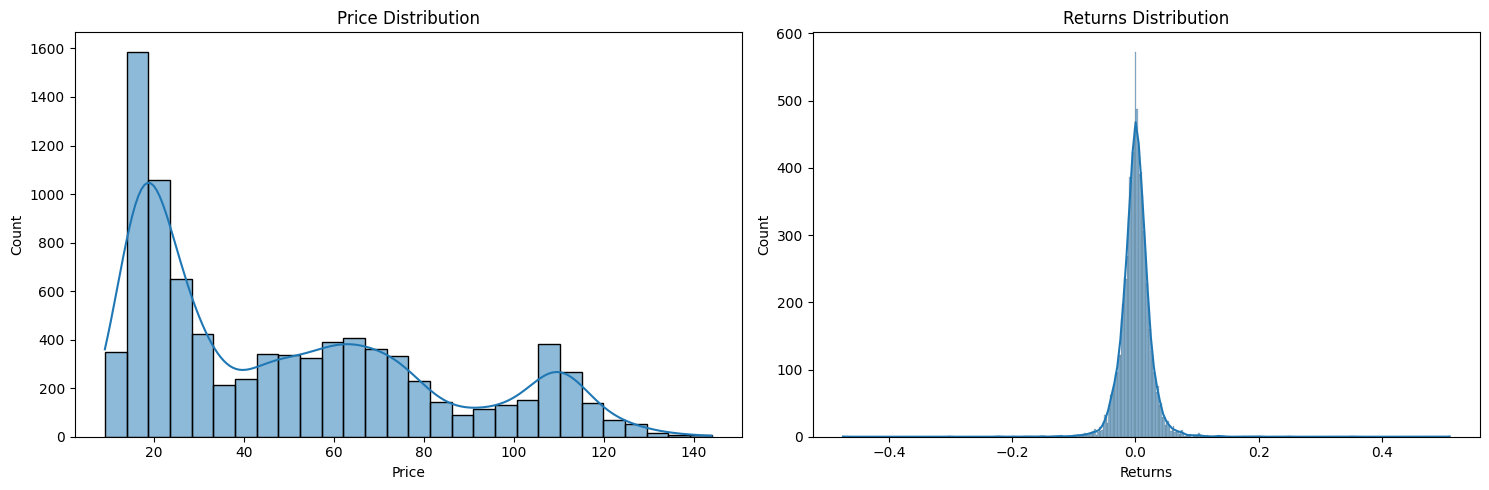

In [14]:
# Visualize distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df['Returns'].dropna(), kde=True)
plt.title('Returns Distribution')
plt.tight_layout()
plt.show()

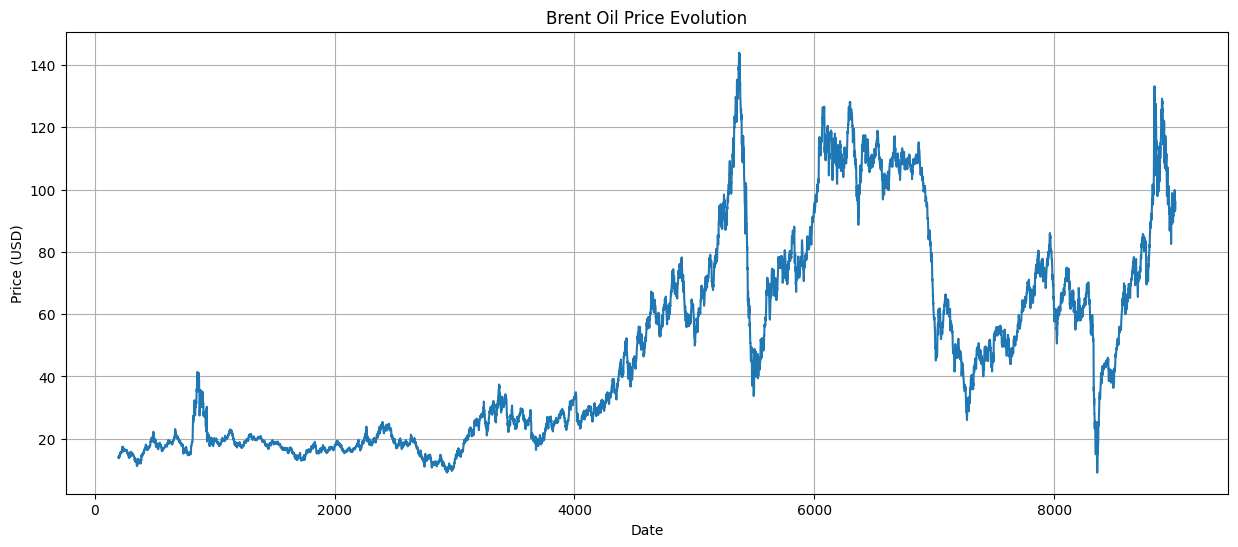

In [15]:
# Plot price evolution
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Price'])
plt.title('Brent Oil Price Evolution')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

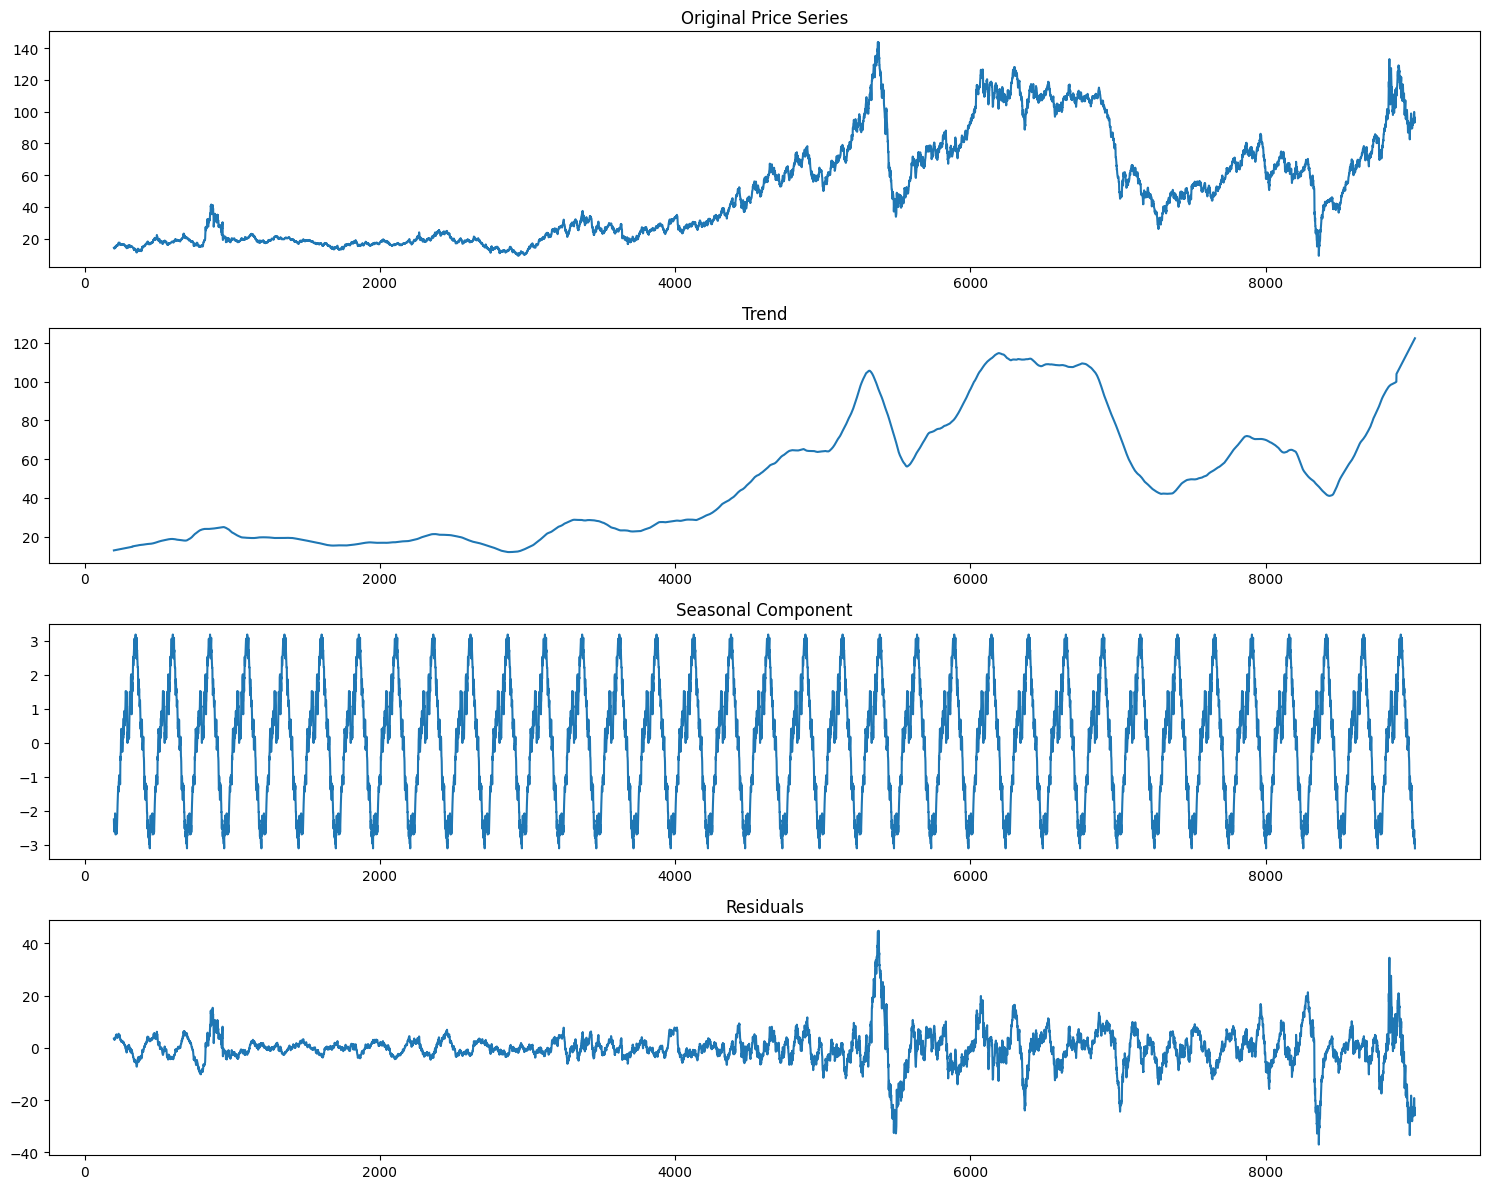

In [16]:
# Analyze seasonality
seasonal_decomp = analyze_seasonality(df['Price'])

# %%
# Plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
ax1.plot(df.index, df['Price'])
ax1.set_title('Original Price Series')
ax2.plot(df.index, seasonal_decomp['trend'])
ax2.set_title('Trend')
ax3.plot(df.index, seasonal_decomp['seasonal'])
ax3.set_title('Seasonal Component')
ax4.plot(df.index, seasonal_decomp['residual'])
ax4.set_title('Residuals')
plt.tight_layout()
plt.show()

In [17]:
# Calculate risk metrics
risk_metrics = calculate_risk_metrics(df['Returns'].dropna())
print("\nRisk Metrics:")
print(f"Value at Risk (5%): {risk_metrics['VaR']:.4f}")
print(f"Conditional VaR: {risk_metrics['CVaR']:.4f}")
print(f"Annual Volatility: {risk_metrics['volatility']:.4f}")
print(f"Downside Risk: {risk_metrics['downside_risk']:.4f}")


Risk Metrics:
Value at Risk (5%): -0.0359
Conditional VaR: -0.0548
Annual Volatility: 0.4034
Downside Risk: 0.3040


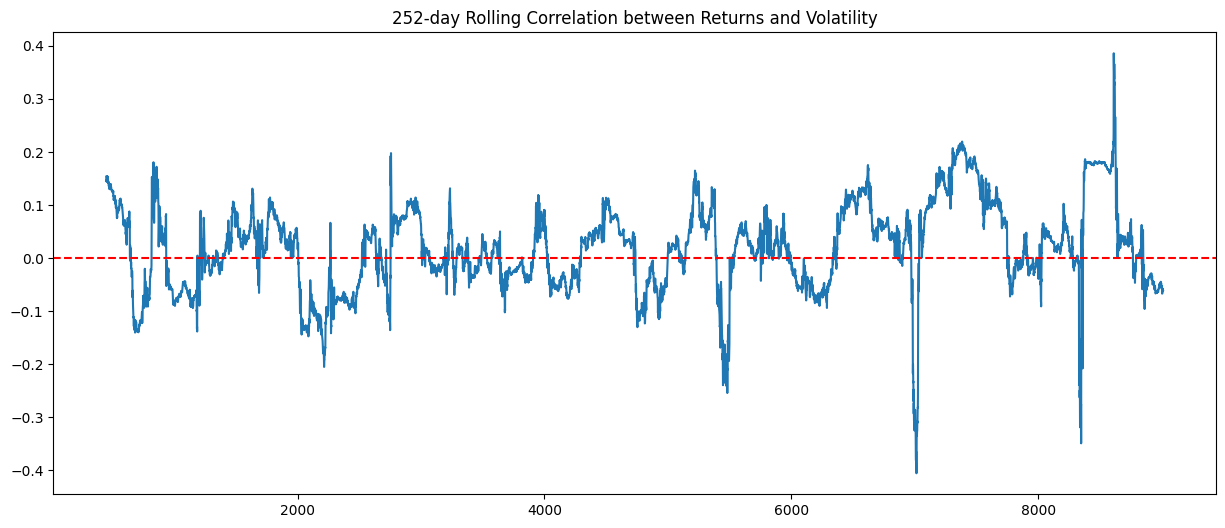

In [18]:
window = 252  # One trading year
rolling_corr = df[['Returns', 'Volatility']].rolling(window=window).corr()
rolling_corr = rolling_corr.unstack()['Returns']['Volatility']

plt.figure(figsize=(15, 6))
plt.plot(rolling_corr.index, rolling_corr.values)
plt.title(f'{window}-day Rolling Correlation between Returns and Volatility')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

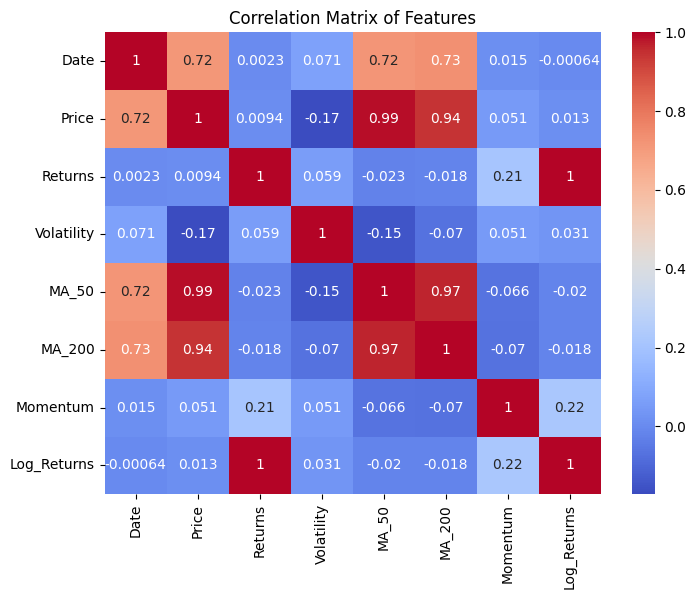

In [19]:
# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


Performing time series analysis...


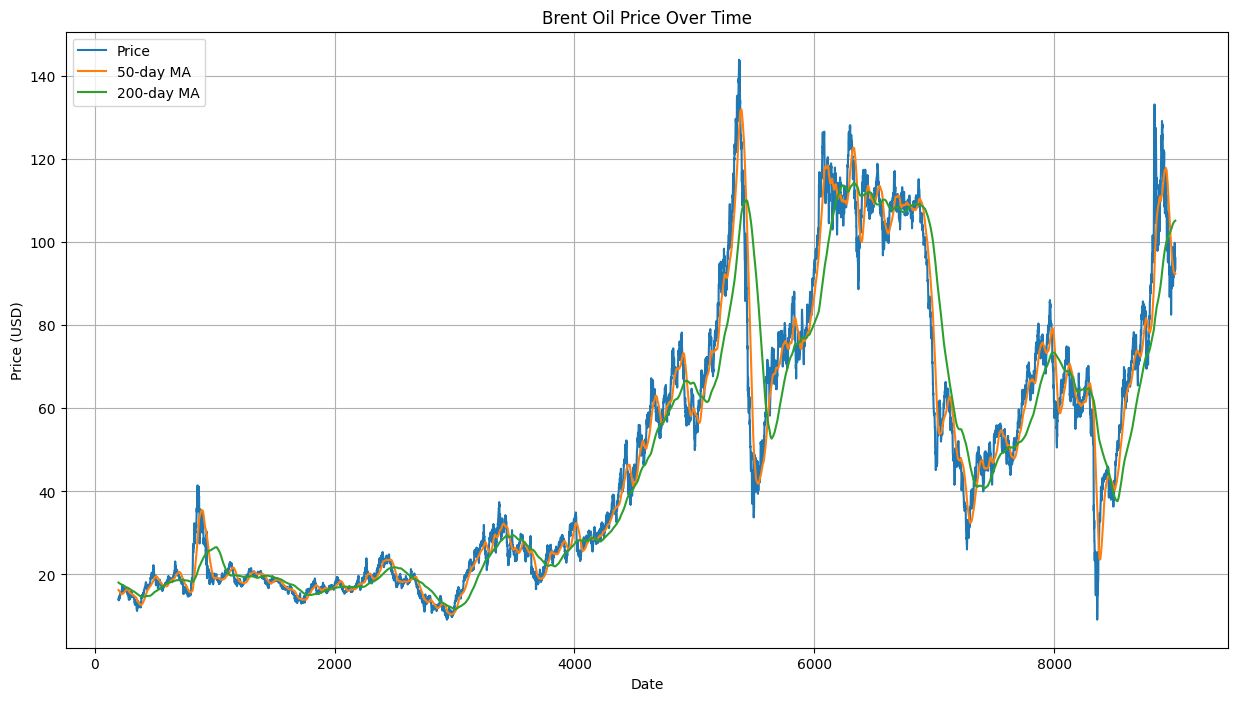

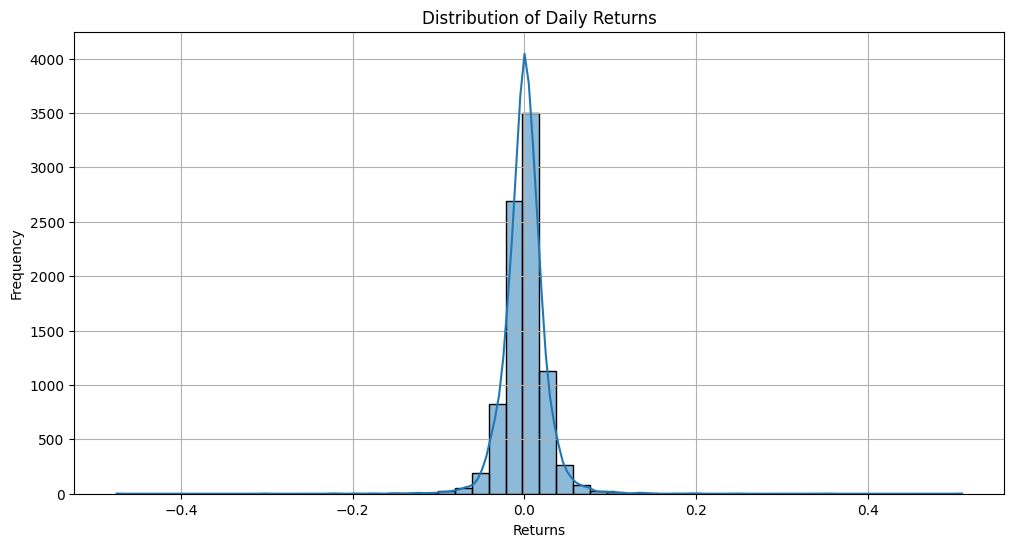

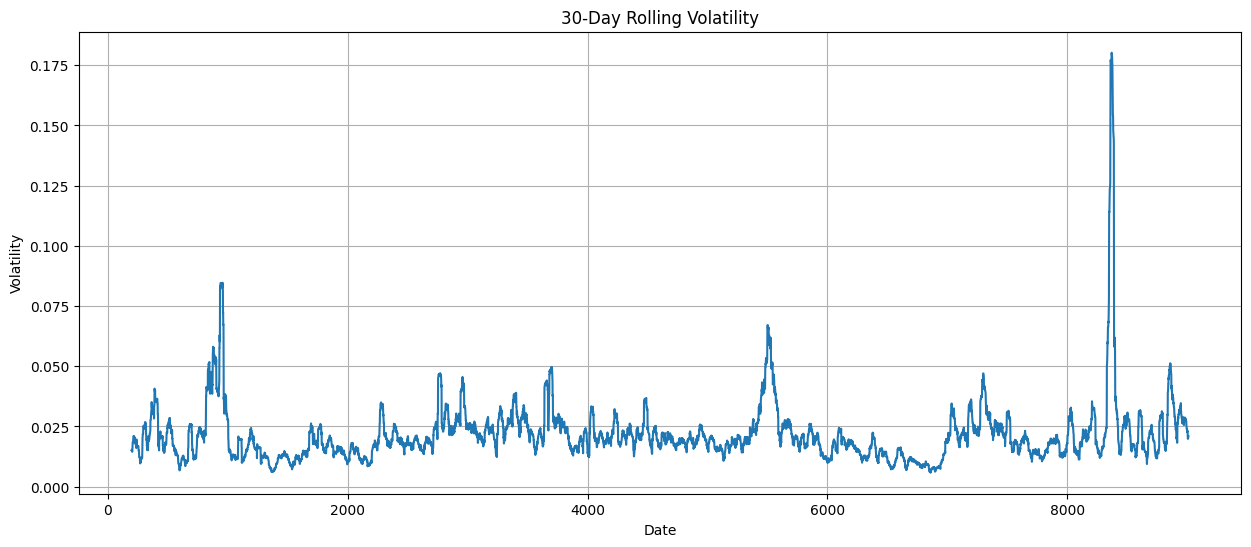

In [20]:
# Time Series Analysis
print("\nPerforming time series analysis...")
plot_time_series(df)
plot_returns_distribution(df)
plot_volatility(df)

#### Stationarity Testing

In [21]:
 # Stationarity Testing
price_stationarity = check_stationarity(df['Price'])
print("Stationarity Test Results for Price:")
print("ADF Statistic:", price_stationarity['ADF Statistic'])
print("p-value:", price_stationarity['p-value'])
print("Critical Values:")
for key, value in price_stationarity['Critical values'].items():
    print(f"   {key}: {value}")


Stationarity Test Results for Price:
ADF Statistic: -2.0170369664542314
p-value: 0.2791533040703682
Critical Values:
   1%: -3.431094843138197
   5%: -2.8618691713324633
   10%: -2.566945212919472


In [22]:
returns_stationarity = check_stationarity(df['Returns'].dropna())
print("\nStationarity Test Results for Returns:")
returns_stationarity


Stationarity Test Results for Returns:


{'ADF Statistic': np.float64(-21.269699973591212),
 'p-value': 0.0,
 'Critical values': {'1%': np.float64(-3.431093572715351),
  '5%': np.float64(-2.8618686099599686),
  '10%': np.float64(-2.566944914097238)}}

#### Autocorrelation Analysis


Analyzing autocorrelation...
Autocorrelation Analysis for Prices:


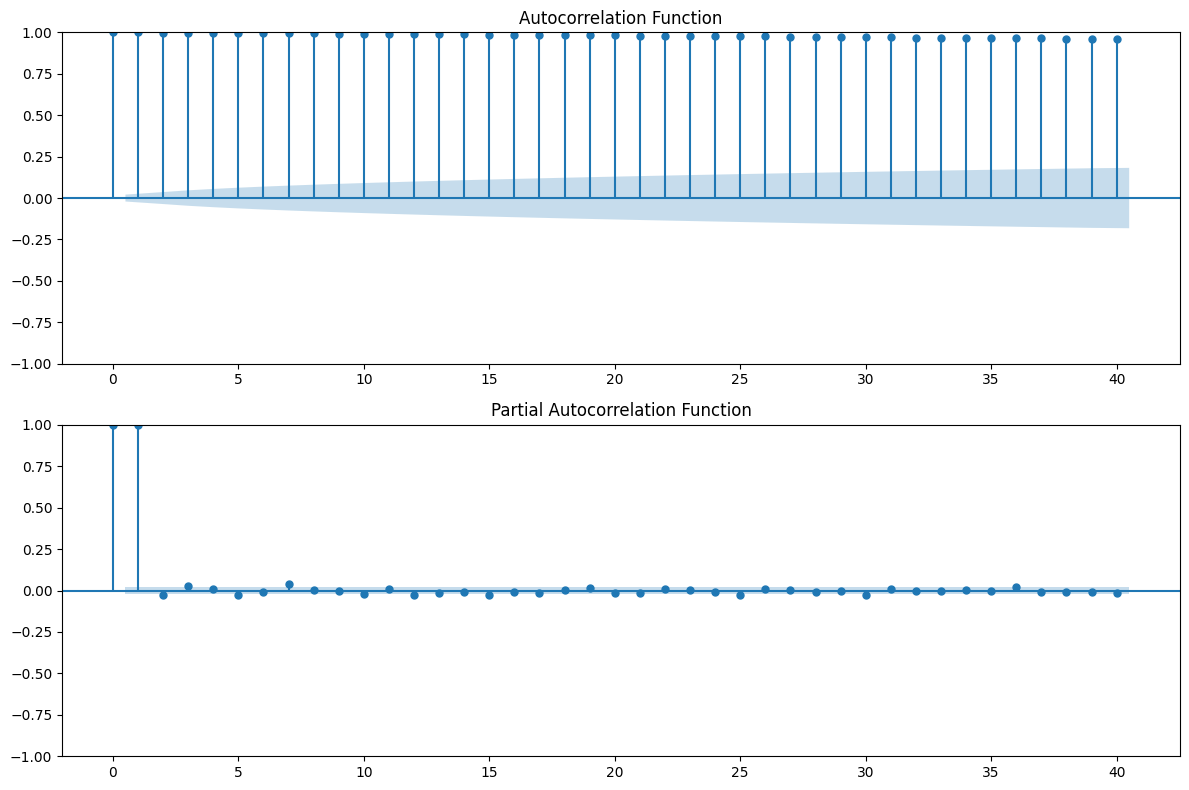


Autocorrelation Analysis for Returns:


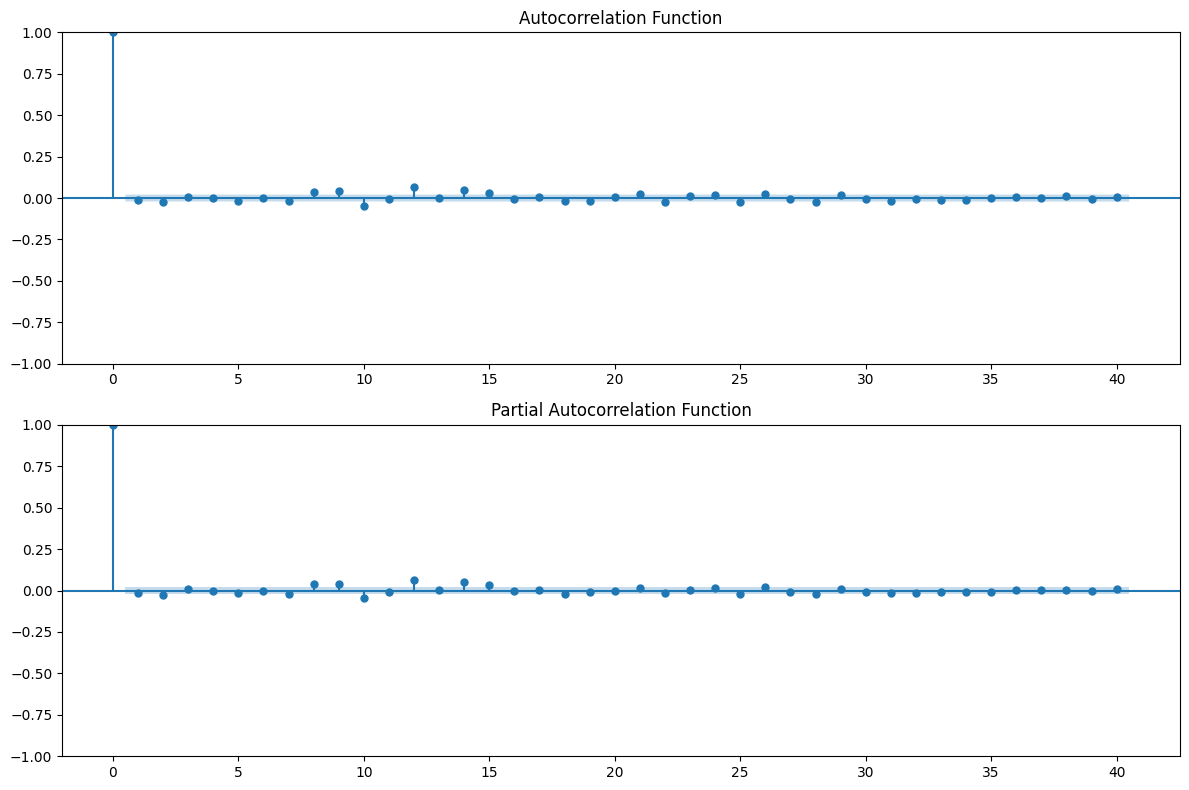

In [23]:
# Autocorrelation Analysis
print("\nAnalyzing autocorrelation...")
print("Autocorrelation Analysis for Prices:")
analyze_autocorrelation(df['Price'])
    
print("\nAutocorrelation Analysis for Returns:")
analyze_autocorrelation(df['Returns'].dropna())

### Summary Statistics

In [24]:
# Assuming summary_stats['date_range']['start'] and ['end'] are timestamps in int64
summary_stats = generate_summary_statistics(df)
start_date = datetime.fromtimestamp(summary_stats['date_range']['start']) if isinstance(summary_stats['date_range']['start'], (int, np.integer)) else summary_stats['date_range']['start']
end_date = datetime.fromtimestamp(summary_stats['date_range']['end']) if isinstance(summary_stats['date_range']['end'], (int, np.integer)) else summary_stats['date_range']['end']

print(f"Date Range: {start_date.date()} to {end_date.date()}")
print(f"Total Trading Days: {summary_stats['date_range']['total_days']}")

Date Range: 1970-01-01 to 1970-01-01
Total Trading Days: 8812


In [25]:
summary_stats

{'date_range': {'start': np.int64(199),
  'end': np.int64(9010),
  'total_days': 8812},
 'price_statistics': {'mean': np.float64(49.10618815251929),
  'std': np.float64(32.906848160661106),
  'min': np.float64(9.1),
  'max': np.float64(143.95),
  'median': np.float64(40.92)},
 'returns_statistics': {'mean': np.float64(0.0005361733816660777),
  'std': np.float64(0.025411772081766624),
  'skewness': np.float64(0.3089858548224369),
  'kurtosis': np.float64(45.24950435105333)},
 'volatility_statistics': {'mean': np.float64(0.021613753236578517),
  'std': np.float64(0.013280297487577631),
  'max': np.float64(0.18017271392902443)}}

In [26]:
print("Price Statistics:")
for key, value in summary_stats['price_statistics'].items():
    print(f"{key.capitalize()}: ${value:.2f}")

Price Statistics:
Mean: $49.11
Std: $32.91
Min: $9.10
Max: $143.95
Median: $40.92


In [27]:
print("\nReturns Statistics:")
for key, value in summary_stats['returns_statistics'].items():
     print(f"{key.capitalize()}: {value:.4f}")



Returns Statistics:
Mean: 0.0005
Std: 0.0254
Skewness: 0.3090
Kurtosis: 45.2495


In [28]:
print("\nVolatility Statistics:")
for key, value in summary_stats['volatility_statistics'].items():
    print(f"{key.capitalize()}: {value:.4f}")


Volatility Statistics:
Mean: 0.0216
Std: 0.0133
Max: 0.1802


### Change Point Detection 

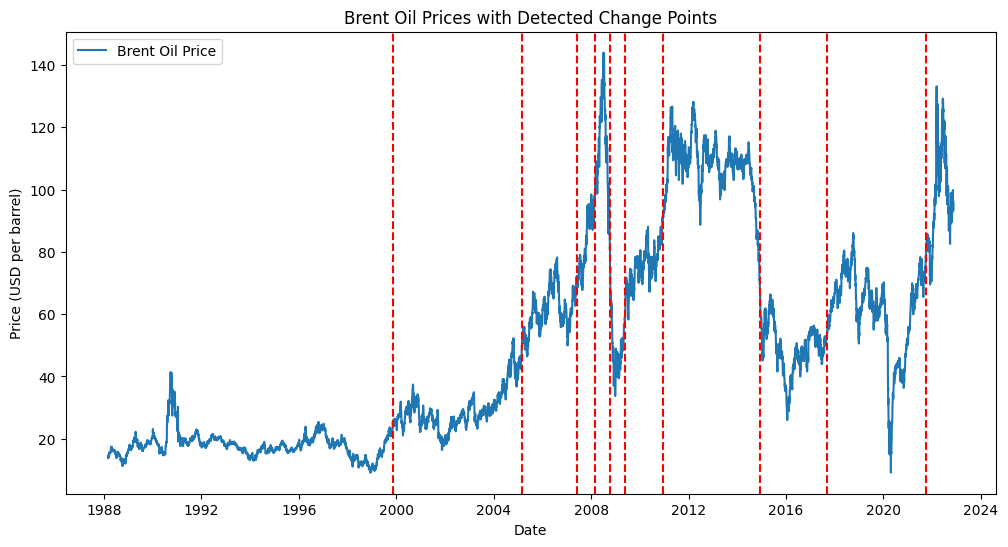

In [29]:
# Convert the price data to a numpy array for change point detection
price_array = df['Price'].values

# Define the change point detection model: Binary Segmentation with the L2 cost function
model = rpt.Binseg(model="l2").fit(price_array)
breakpoints = model.predict(n_bkps=10)  # We can adjust the number of breakpoints as needed

# Filter out the last breakpoint if it is equal to the length of the array
breakpoints = [bkpt for bkpt in breakpoints if bkpt < len(price_array)]

# Plot the detected change points
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Brent Oil Price')
for bkpt in breakpoints:
    plt.axvline(df['Date'].iloc[bkpt], color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.show()

###  Event Markers 

In [30]:
# Define major events 
events = pd.DataFrame({
    'Date': pd.to_datetime([
        '2008-09-15',  # Lehman Brothers collapse, start of Global Financial Crisis
        '2011-04-01',  # 2011 Arab Spring impact on oil prices
        '2014-06-01',  # Start of 2014 oil price crash
        '2016-01-01',  # 2016 oil price bottom
        '2019-09-14',  # Saudi Aramco oil facility attack
        '2020-03-01',  # COVID-19 impact
        '2020-04-20',  # WTI oil futures went negative
        '2022-02-24',  # Russia-Ukraine conflict
        '2023-04-02',  # OPEC+ announces surprise production cuts
        

    ]),
    'Event': [
        '2008 Financial Crisis',
        '2011 Arab Spring',
        '2014 Oil Price Crash',
        '2016 Price Bottom',
        'Saudi Aramco Attack',
        'COVID-19 Impact',
        'Negative Oil Prices',
        'Russia-Ukraine Conflict',
        'OPEC+ Production Cuts'
    ]
})

In [31]:
df.set_index('Date', inplace=True)

In [32]:
# Analyze price behavior around events
window = 30  # Days to analyze before and after each event

def analyze_event_impact(df, event_date, window):
    start_date = event_date - pd.Timedelta(days=window)
    end_date = event_date + pd.Timedelta(days=window)
    
    event_period = df[start_date:end_date]
    if len(event_period) == 0:
        return None
    
    return {
        'price_change': (event_period['Price'][-1] / event_period['Price'][0] - 1) * 100,
        'max_drawdown': (event_period['Price'] / event_period['Price'].cummax() - 1).min() * 100,
        'volatility': event_period['Returns'].std() * np.sqrt(252) * 100
    }


# Calculate impact for each event
event_impacts = []
for _, event in events.iterrows():
    impact = analyze_event_impact(df, event['Date'], window)
    if impact:
        impact['Event'] = event['Event']
        event_impacts.append(impact)

event_impacts_df = pd.DataFrame(event_impacts)
print("\nEvent Impact Analysis:")
print(event_impacts_df)


Event Impact Analysis:
   price_change  max_drawdown  volatility                    Event
0    -38.845697    -42.971682   57.218506    2008 Financial Crisis
1      8.298400     -5.073146   25.369368         2011 Arab Spring
2      1.242236     -3.776369   11.405488     2014 Oil Price Crash
3    -20.944656    -38.071429   52.537271        2016 Price Bottom
4      2.510023    -15.346390   46.271387      Saudi Aramco Attack
5    -66.782067    -68.067649   99.493607          COVID-19 Impact
6     38.707103    -64.402810  248.242904      Negative Oil Prices
7     37.076768    -21.452170   63.049616  Russia-Ukraine Conflict


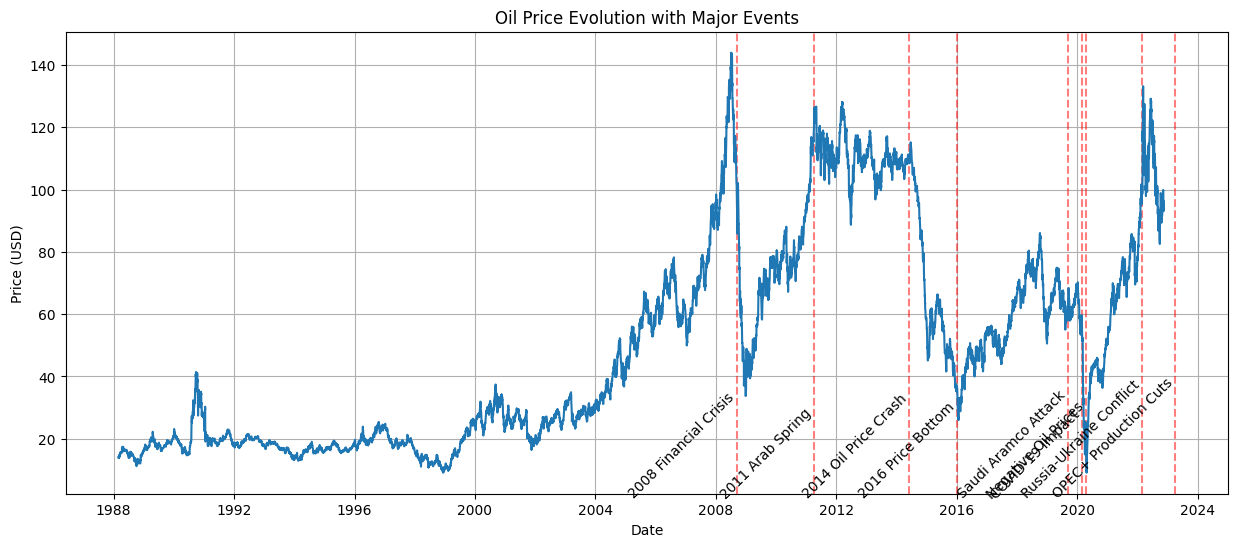

In [33]:
# Visualize event impacts
plt.figure(figsize=(15, 6))
for _, event in events.iterrows():
    plt.axvline(event['Date'], color='r', linestyle='--', alpha=0.5)
    plt.text(event['Date'], plt.ylim()[1], event['Event'], 
             rotation=45, ha='right')

plt.plot(df.index, df['Price'])
plt.title('Oil Price Evolution with Major Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


In [34]:
#df.set_index('Date', inplace=True)
df.to_csv('../data/price_with_features.csv')